In [1]:
import numpy as np
import quaternion as qt
import library.ulogReader as ur
import library.quaternionUtils as qu
import library.choleskyDecomposition as cd
import library.quaternionVisualization as qv

from pyulog import ULog

## Wczytanie danych lotu drona

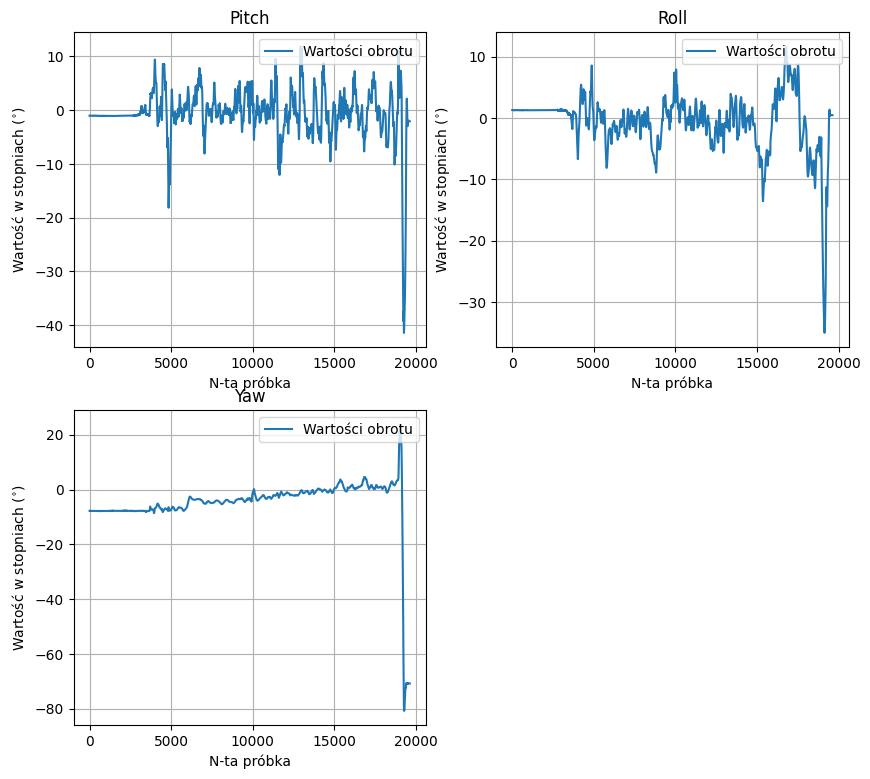

In [2]:
ulog_path = './ulogs/639_bs10_out_alt.ulg'
ulog = ULog(ulog_path)

attitude, attitude_time  = ur.readAttitude(ulog)
attitude_time = (attitude_time - attitude_time[0]) / 1e3

qv.display_quat_as_euler([attitude], [range(attitude.shape[0])], ['Wartości obrotu'])


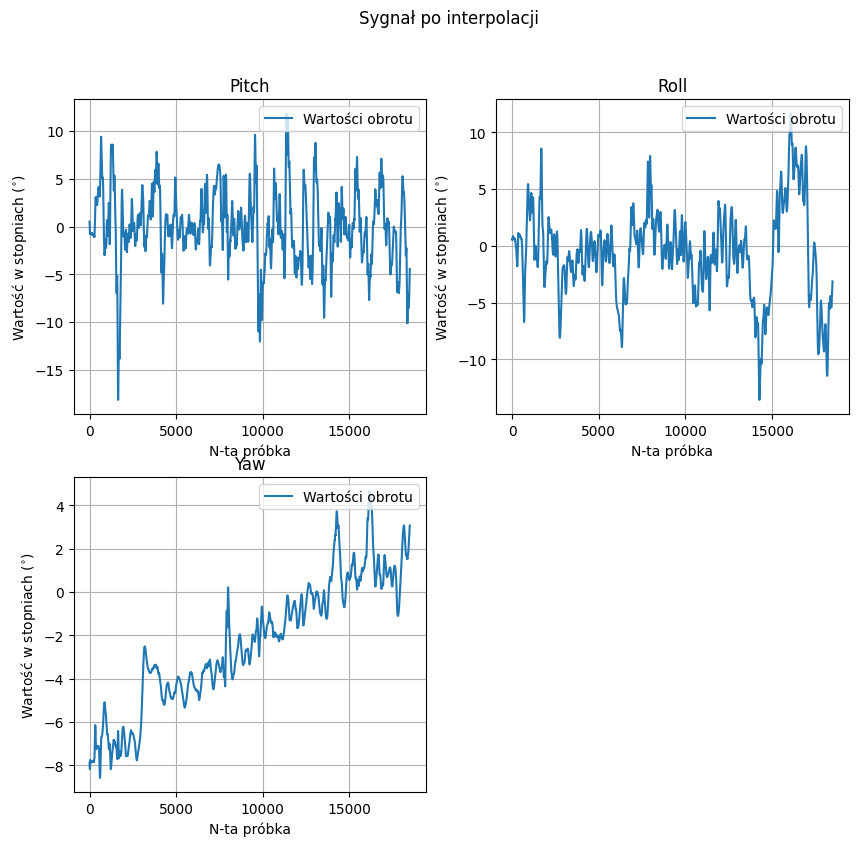

In [3]:
start_time = 8e3   
end_time   = 45e3

# Config interpolation
dt = 2      # Delta time in ms
degree = 3  # Spline degree

# Post resampling time
it_t = np.arange(start_time, end_time, dt)
attitude = qu.splineInterpolation(attitude, attitude_time, it_t, degree)
attitude_time = it_t

qv.display_quat_as_euler([attitude], [range(attitude.shape[0])], ['Wartości obrotu'], title='Sygnał po interpolacji')

### Metoda Yule-Walkera
---  

In [37]:
P_ORDER    = 5
DOWN_SAMPLING = 5
K_FORECAST = [1,3,7]
N_WINDOW = 8           # Minimal value (N_WINDOW > P_ORDER + 1)
START_WINDOW = 30
MU = 5e-3

x = np.copy(attitude)[::DOWN_SAMPLING]
y = np.ones((len(K_FORECAST), x.shape[0] + max(K_FORECAST)), dtype = qt.quaternion)

corr_matrix = qu.correlationMatrix(x[:START_WINDOW][::-1], P_ORDER + 1 , normalize=True)

for i in range(START_WINDOW, x.shape[0]+1):
    tmp_corr_matrix = qu.correlationMatrix(x[i-N_WINDOW : i][::-1], P_ORDER + 1, normalize=True)
    corr_matrix = (1-MU) * corr_matrix + MU * tmp_corr_matrix
    tmp_corr_matrix = np.copy(corr_matrix)
    np.fill_diagonal(tmp_corr_matrix, tmp_corr_matrix.diagonal()+qt.quaternion(1e-6,0,0,0))
    l = cd.choleskyDecomposition(tmp_corr_matrix[:-1, :-1])
    w = cd.solveLLHEquation(l, tmp_corr_matrix[1:,0])

    for k, k_steps in enumerate(K_FORECAST):
        y[k, i + k_steps - 1] = qu.predictionKSteps(np.copy(x[i-P_ORDER-1 : i][::-1]), np.concatenate(([qt.quaternion(1,0,0,0)],w)), k_steps)

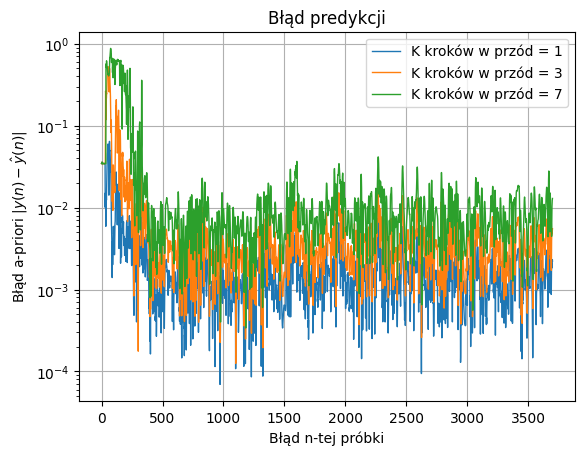

In [41]:
qv.displayPredictionError(x,y,K_FORECAST, label_form='K kroków w przód = {}')

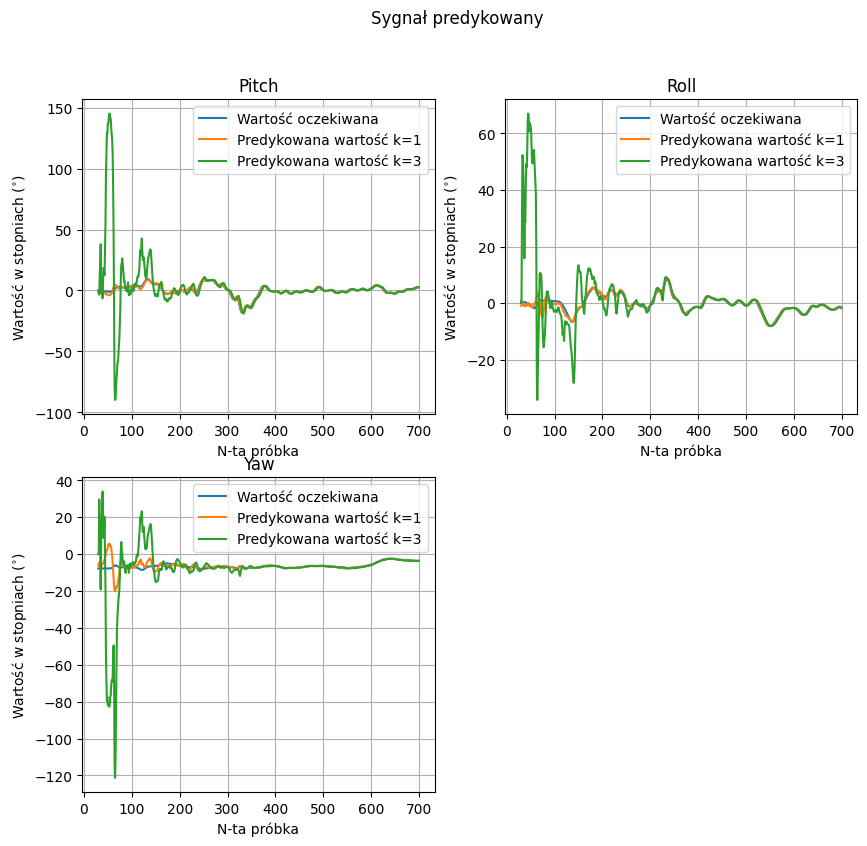

In [60]:
start_value = START_WINDOW
end_value = 700

qv.display_quat_as_euler([x[start_value:end_value], 
                          y[0, start_value:end_value],
                          y[1, start_value:end_value],], 
                         [range(start_value,end_value), 
                          range(start_value,end_value),
                          range(start_value,end_value),], 
                         ['Wartość oczekiwana', 
                          'Predykowana wartość k=1',
                          'Predykowana wartość k=3',
                          ], title='Sygnał predykowany')

### Wyznaczenie optymalnych parametrów filtru

In [10]:
def predictionGain(qPrediction, qRference):
    f_predicted = qt.as_float_array(qPrediction)
    f_source    = qt.as_float_array(qRference)

    predGain = np.average( 10*np.log10(
        np.sum((f_predicted)**2, axis=1) /
        np.sum((f_predicted-f_source)**2, axis=1)))
    
    return predGain

In [11]:
DOWN_SAMPLING = 5
START_WINDOW = 30
K_FORECAST = [1,3,7]
MU = 5e-3

p_orders = np.arange(2, 10, 1)
max_n_window = 15
window_step = 1

prediction_gains = np.zeros((len(K_FORECAST), p_orders[-1]+1, max_n_window+1))

x = np.copy(attitude)[::DOWN_SAMPLING]


for n, p_order in enumerate(p_orders):
    n_windows = np.arange(p_order + 2, max_n_window, window_step)

    for m, n_window in enumerate(n_windows):

        corr_matrix = qu.correlationMatrix(x[:START_WINDOW][::-1], p_order + 1 , normalize=True)
        y = np.ones((len(K_FORECAST), x.shape[0] + max(K_FORECAST)), dtype = qt.quaternion)


        for i in range(START_WINDOW, x.shape[0]+1):
            tmp_corr_matrix = qu.correlationMatrix(x[i-n_window : i][::-1], p_order + 1, normalize=True)
            corr_matrix = (1-MU) * corr_matrix + MU * tmp_corr_matrix
            tmp_corr_matrix = np.copy(corr_matrix)
            np.fill_diagonal(tmp_corr_matrix, tmp_corr_matrix.diagonal()+qt.quaternion(1e-6,0,0,0))
            l = cd.choleskyDecomposition(tmp_corr_matrix[:-1, :-1])
            w = cd.solveLLHEquation(l, tmp_corr_matrix[1:,0])

            for k, k_steps in enumerate(K_FORECAST):
                y[k, i + k_steps - 1] = qu.predictionKSteps(np.copy(x[i-p_order-1 : i][::-1]), np.concatenate(([qt.quaternion(1,0,0,0)],w)), k_steps)

        for k, k_steps in enumerate(K_FORECAST):
            prediction_gains[k, p_order, n_window] = predictionGain(y[k, START_WINDOW:x.shape[0]], x[START_WINDOW:])

In [14]:
import plotly.graph_objects as go
import numpy as np

result = np.where(prediction_gains != 0, prediction_gains, float("nan"))
pred = 1

fig = go.Figure(data=[
    go.Surface(z=result[pred]),
    ])

fig.update_layout(scene = dict(
                    xaxis_title='N - Rozmiar okna',
                    yaxis_title='P - Ilość współczynników',
                    zaxis_title='Wartość predykcji (db)'),
                    width=700,
                    margin = dict(r=20, b=10, l=10, t=40),
                    xaxis = dict(nticks=4, range=[-100,100],),
                    title='Predykcja {} kroki w przód'.format(K_FORECAST[pred]),
                    )

fig.show()


In [15]:
START_WINDOW = 30
K_FORECAST = [1,3,7]
P_ORDER    = 5
N_WINDOW = 8 

down_samplings = np.arange(1, 16, 1)
mus = np.array([1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5])

prediction_gains_md = np.zeros((len(K_FORECAST), down_samplings[-1]+1, mus.shape[0]))

for l, d_sam in enumerate(down_samplings):
    x = np.copy(attitude)[::d_sam]

    for m, mu in enumerate(mus):

        corr_matrix = qu.correlationMatrix(x[:START_WINDOW][::-1], P_ORDER + 1 , normalize=True)
        y = np.ones((len(K_FORECAST), x.shape[0] + max(K_FORECAST)), dtype = qt.quaternion)

        for i in range(START_WINDOW, x.shape[0]+1):
            tmp_corr_matrix = qu.correlationMatrix(x[i-N_WINDOW : i][::-1], P_ORDER + 1, normalize=True)
            corr_matrix = (1-mu) * corr_matrix + mu * tmp_corr_matrix
            tmp_corr_matrix = np.copy(corr_matrix)
            np.fill_diagonal(tmp_corr_matrix, tmp_corr_matrix.diagonal()+qt.quaternion(1e-6,0,0,0))
            l = cd.choleskyDecomposition(tmp_corr_matrix[:-1, :-1])
            w = cd.solveLLHEquation(l, tmp_corr_matrix[1:,0])

            for k, k_steps in enumerate(K_FORECAST):
                y[k, i + k_steps - 1] = qu.predictionKSteps(np.copy(x[i-P_ORDER-1 : i][::-1]), np.concatenate(([qt.quaternion(1,0,0,0)],w)), k_steps)

        for k, k_steps in enumerate(K_FORECAST):
            prediction_gains_md[k, d_sam, m] = predictionGain(y[k, 500:x.shape[0]], x[500:])


In [17]:
import plotly.graph_objects as go
import numpy as np

result = np.where(prediction_gains_md != 0, prediction_gains_md, float("nan"))
pred = 1

fig = go.Figure(data=[
    go.Surface(z=result[pred]),
    ])

fig.update_layout(scene = dict(
                    xaxis_title='M Wsp. zapominania',
                    yaxis_title='D stopień decymacji',
                    zaxis_title='Wartość predykcji (db)'),
                    width=700,
                    margin = dict(r=20, b=10, l=10, t=40),
                    title='Predykcja {} kroki w przód'.format(K_FORECAST[pred]),
                    )

fig.update_layout(scene = dict(
                    xaxis = dict(
                        ticktext= [1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5],
                        tickvals= [i for i in range(mus.shape[0])]),
                    )
                  )

fig.show()
